In [109]:
import pandas as pd
import re
from nltk.corpus import stopwords
import redditcleaner
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import gensim
import gensim.corpora as corpora
import nltk
from tqdm import tqdm
from gensim.models.coherencemodel import CoherenceModel
import warnings
from gensim import corpora, models
import en_core_web_sm
warnings.simplefilter("ignore", DeprecationWarning)
from sklearn.decomposition import LatentDirichletAllocation as LDA
from pprint import pprint
import pickle

In [75]:
#dataset
df_pre = pd.read_csv('liwc_abuse_prepandemic.csv')

In [76]:
df_pre.head()

,Post ID,Title,Body,Author,Publish Date,No. Comments,WC,Analytic,Clout,Authentic,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,9t93dw,Is this sibling abuse?,This happened when I was younger and I just wa...,PauljAdams,2018-11-01 05:46:50,2,403,14.55,43.09,81.16,...,0.25,0.00,0.0,0.74,0.0,0.00,0.50,1.74,0.50,0.00
1,9t9wla,dad is going to “smash my phone with a hammer”...,title. for the first time this year i was late...,DEAD2002,2018-11-01 07:30:01,4,70,68.29,28.39,97.55,...,1.43,0.00,0.0,1.43,0.0,2.86,5.71,0.00,0.00,1.43
2,9tcb0h,I’m terrified of my brother and can’t escape,This is my first post on reddit so sorry if my...,donutbelikethat,2018-11-01 11:54:15,5,688,14.04,47.67,69.90,...,2.62,0.00,0.0,0.00,0.0,0.00,0.29,2.62,0.00,0.44
3,9tj590,I have a abusive bother looking for suggestions.,This is my first ever post to reddit so sorry ...,ARetardedCanadian,2018-11-02 04:22:03,3,489,4.87,27.67,81.51,...,0.41,0.00,0.0,0.00,0.0,0.00,0.00,5.73,0.41,0.00
4,9tk88w,My ex bf abused me over 3 years ago,I have told this before to people and been in ...,zwerrifer,2018-11-02 06:46:57,0,351,27.45,14.59,93.12,...,3.13,0.28,0.0,0.00,0.0,0.00,0.00,1.71,2.28,0.85


### Adding LIWC Values of Submissions 

In [77]:
personal_concerns = ['work', 'leisure', 'home', 'money', 'relig', 'death']
col_pre = ['affect', 'social', 'cogproc', 'percept', 'bio', 'drives', 'time', 'relativ', 'informal']

valueCount_pre = {}

totalPre = 0
for item in col_pre:
    try:
        valueCount_pre[item].add(df_pre[item].values.sum())
        for i in valueCount_pre[item]:
            totalPre += float(i)
    except:
        valueCount_pre[item] = [df_pre[item].values.sum()]
        for i in valueCount_pre[item]:
            totalPre += float(i)
    
print('-------')

for item in valueCount_pre:
    for val in valueCount_pre[item]:
        norm = float(val)/totalPre
        valueCount_pre[item] = norm

print(valueCount_pre)

-------
{'affect': 0.11196630294713958, 'social': 0.201343690055758, 'cogproc': 0.19693065666453763, 'percept': 0.03770724888440067, 'bio': 0.03868716197973373, 'drives': 0.11570590184311018, 'time': 0.08595318333700619, 'relativ': 0.1957821049579149, 'informal': 0.01592374933039918}


['affect', 'social', 'cogproc', 'percept', 'bio', 'drives', 'time', 'relativ', 'informal']
[0.11196630294713958, 0.201343690055758, 0.19693065666453763, 0.03770724888440067, 0.03868716197973373, 0.11570590184311018, 0.08595318333700619, 0.1957821049579149, 0.01592374933039918]


<Figure size 1000x1000 with 0 Axes>

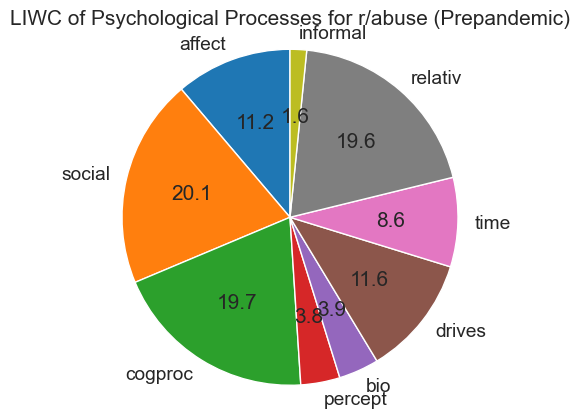

In [78]:
labels_pre = []
data_pre = []
for k in valueCount_pre:
    labels_pre.append(k)
    num = float(valueCount_pre[k])
    data_pre.append(num)
print(labels_pre)
print(data_pre)
plt.figure(figsize=(10,10))
figureObject_pre, axesObject_pre = plt.subplots()
axesObject_pre.pie(data_pre,

        labels=labels_pre,

        autopct='%1.1f',

        startangle=90)

axesObject_pre.axis('equal')

axesObject_pre.set_title('LIWC of Psychological Processes for r/abuse (Prepandemic)', fontsize=15)

plt.show()

In [79]:
# top 30 most dominant features for midpandemic
count = 0
for w in sorted(valueCount_mid, key=valueCount_mid.get, reverse=True):
    if count <= 30:
        print(w, valueCount_mid[w])
        count += 1

In [80]:
# top 30 most dominant features for prepandemic
count = 0
for w in sorted(valueCount_pre, key=valueCount_pre.get, reverse=True):
    if count <= 30:
        print(w, valueCount_pre[w])
        count += 1

social 0.201343690055758
cogproc 0.19693065666453763
relativ 0.1957821049579149
drives 0.11570590184311018
affect 0.11196630294713958
time 0.08595318333700619
bio 0.03868716197973373
percept 0.03770724888440067
informal 0.01592374933039918


In [88]:

df_pre['Body'] = df_pre['Body'].astype('str')


## Preprocessing Body Text

In [89]:
#Removing stop words
pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
df_pre['subm_text_processed'] = df_pre['Body'].map(lambda x: re.sub(pattern, '', x))

#redditclean

df_pre['subm_text_processed'] = df_pre['subm_text_processed'].map(redditcleaner.clean)


#Removing x200b

df_pre['subm_text_processed'] = df_pre['subm_text_processed'].map(lambda x: re.sub('x200b', '', x))



#Removing url links
df_pre['subm_text_processed'] = df_pre['subm_text_processed'].map(lambda x: re.sub('(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*', '', x))

#Removing ampersands
df_pre['subm_text_processed'] = df_pre['subm_text_processed'].map(lambda x: re.sub('amp', '', x))


#Removing nan

df_pre['subm_text_processed'] = df_pre['subm_text_processed'].map(lambda x: re.sub('nan', '', x))

#Removing new line tabs

df_pre['subm_text_processed'] = df_pre['subm_text_processed'].map(lambda x: re.sub('[\n]', '', x))


# Remove punctuation
df_pre['subm_text_processed'] = df_pre['subm_text_processed'].map(lambda x: re.sub('[,\.*!?]', '', x))


# Convert the titles to lowercase

df_pre['subm_text_processed'] = df_pre['subm_text_processed'].map(lambda x: x.lower())


# Print out the first rows of papers
df_pre['subm_text_processed'].head()


0    this happened i younger i want clarification h...
1    title first time year late school - 5 minutes ...
2    this first post reddit sorry structure awful i...
3    this first ever post reddit sorry seems weirdl...
4    i told people therapy though '3 years ago i'st...
Name: subm_text_processed, dtype: object

### Common Words in Submissions

In [90]:
# Join the different processed titles together.
long_string_pre = ','.join(list(df_pre['subm_text_processed'].values))


# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')


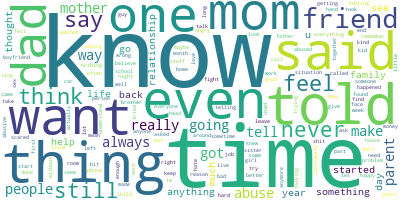

In [91]:
wordcloud.generate(long_string_pre)
wordcloud.to_image()

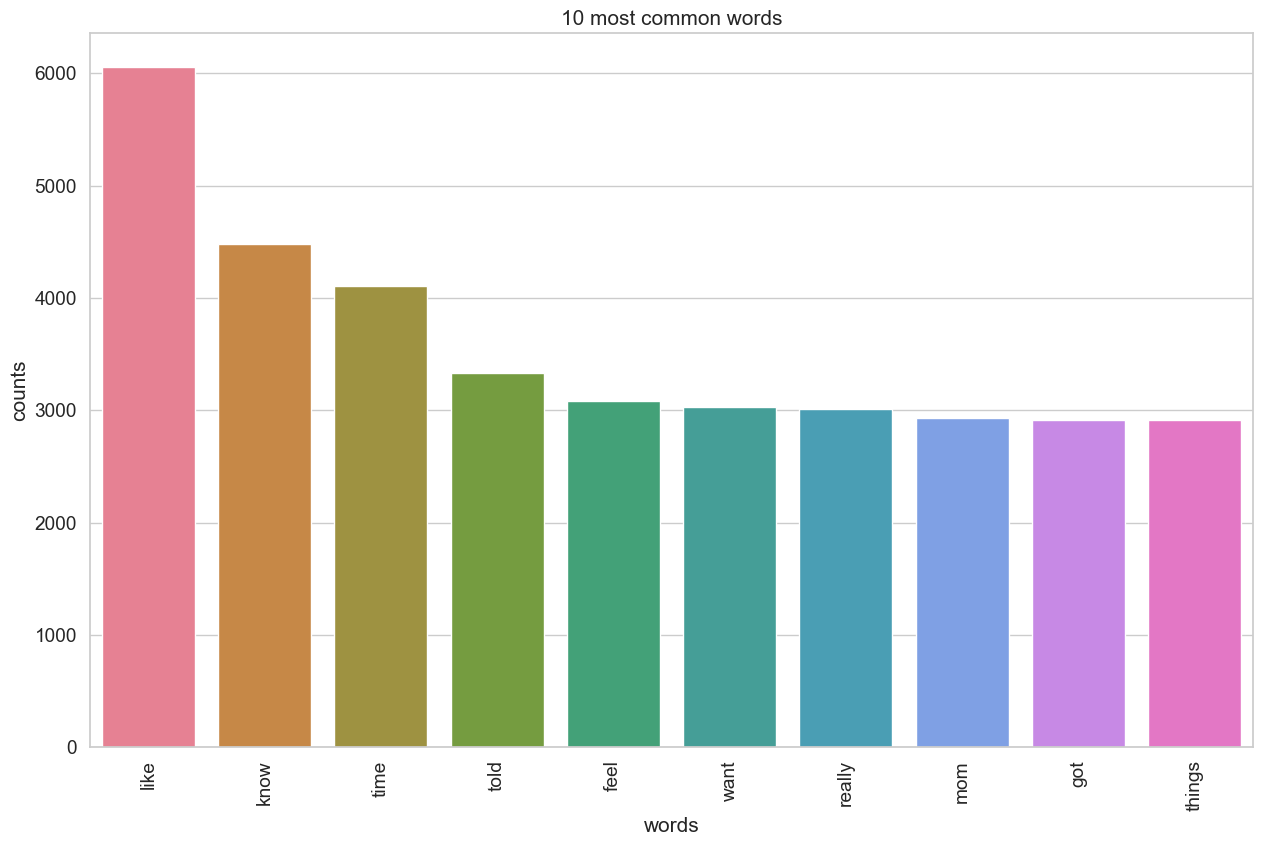

In [102]:
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names_out()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]

    x_pos = np.arange(len(words)) 

    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x=x_pos, y=counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialize the count vectorizer with the English stop words
count_vectorizer_pre = CountVectorizer(stop_words='english')

# Fit and transform the processed titles

count_data_pre = count_vectorizer_pre.fit_transform(df_pre['subm_text_processed'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data_pre, count_vectorizer_pre)

## Building LDA Topic Model

### Creating the baseline model

In [108]:
stopwords = nltk.corpus.stopwords.words('english')

#filtering out frequent words that appeared multiple times in topics
top_words = ['feel', 'want', 'friend', 'time', 'abuse', 'people', 'tell', 'think', 'year', 'thing', 'leave', 'start',
            'talk', 'need', 'parent']

stopwords.extend(top_words)
print(stopwords)

# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

        
def tokenization_with_gen_stop(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)

    return result

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [106]:
#nlp = spacy.load("en_core_web_sm")
nlp = en_core_web_sm.load()
nlp_pre = en_core_web_sm.load()

# data_lemma = []
data_lemma_pre = []



for txt in tqdm(df_pre['subm_text_processed']):
    lis = []
    doc = nlp_pre(txt)
    for token in doc:
        lis.append(token.lemma_)
    data_lemma_pre.append(' '.join(lis))
    

# data_words = []
data_words_pre = []

# for txt in tqdm(data_lemma):
#     data_words.append(tokenization_with_gen_stop(txt))

for txt in tqdm(data_lemma_pre):
    data_words_pre.append(tokenization_with_gen_stop(txt))

# data_words_clean = []
data_words_clean_pre = []

# for word in tqdm(data_words):
#     wrd = []
#     for w in word:
#         if w not in stopwords:
#             wrd.append(w)
#     data_words_clean.append(wrd)
print(stopwords)
for word in tqdm(data_words_pre):
    wrd = []
    for w in word:
        if w not in stopwords:
            wrd.append(w)
    data_words_clean_pre.append(wrd)

# dictionary = corpora.Dictionary(data_words_clean)
# dictionary.filter_extremes(no_below=3)
# corpus = [dictionary.doc2bow(text) for text in data_words_clean]

dictionary_pre = corpora.Dictionary(data_words_clean_pre)
dictionary_pre.filter_extremes(no_below=3)
corpus_pre = [dictionary_pre.doc2bow(text) for text in data_words_clean_pre]



num_topics = 10

# print('------Midpandemic Topic Model-----------')

# %time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
#                                  id2word=dictionary, \
#                                   passes=5, alpha=[0.01]*num_topics, \
#                                   eta=[0.01]*len(dictionary.keys()))

# for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=4):
#     print(str(i)+": "+ topic)
#     print()
    
%time lda_model_pre = models.LdaModel(corpus_pre, num_topics=num_topics, \
                                 id2word=dictionary_pre, \
                                  passes=5, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_pre.keys()))

print('------Prepandemic LDA Mallet Topic Model-----------')

for i,topic in lda_model_pre.show_topics(formatted=True, num_topics=num_topics, num_words=1):
    print(str(i)+": "+ topic)
    print()

  0%|          | 0/3488 [00:00<?, ?it/s]


TypeError: argument of type 'WordListCorpusReader' is not iterable

In [ ]:
# Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_clean, dictionary=dictionary, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# # this is the baseline LDA Model
# print('\n MidPandemic Coherence Score: ', coherence_lda)


 MidPandemic Coherence Score:  0.2805064425429292
